# Decision Tree Classifier

In this notebook, we explore and tune the parameters for the DecisionTreeClassifier to predict if PA forms will be approved. We will be using Drug, BIN, Reject Code, and flags for Tried & Failed, Contraindication, and Correct Diagnosis. for prediciton. First, we import the needed packages.

In [1]:
##Import packages
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Import packages
## tree will be used to plot the decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Import splits and metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

Now, we create our train test split, making sure to stratify on PA approval. We choose a test size of .2, and use the same random seed in all other method notebooks. We will use the test set after choosing our final model (and not in this notebook).

In [3]:
#import cleaned CSV (no date information)
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)

#drop pa_approved for the predictors, only use it for target.
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()
X_train,X_test,y_train,y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

## Baseline Model

Our baseline model will be predicting all claims will have PA approved, as the majority of claims are approved.

In [4]:
if y_train.value_counts(normalize=True)[1]>.5:
    print(np.round(y_train.value_counts(normalize=True)[1]*100,3),"percent of the training set has PA approved",
          "our baseline model will predict all PA forms are approved.")
else:
    print(np.round(y_train.value_counts(normalize=True)[1]*100,3),"percent of the training set has PA approved",
          "our baseline model will predict all PA forms are declined.")

73.445 percent of the training set has PA approved our baseline model will predict all PA forms are approved.


## Cross-Validation
We perform 5-fold cross validation to explore the accuracy rate and roc_auc as we change max depth and gini/entropy.

### Max-depth
Here, we look at varying max_depth of the tree from 3 to 14 levels. We will compare the average (over the validation sets) accuracy and ROC-AUC scores for each depth, along with our baseline model.

In [5]:
#kfold cross validation, and max_depth range
kfold = StratifiedKFold(5, shuffle=True, random_state=10475)
depth = range(3,15)

#matrices to hold accuracy and ROC-AUC scores for validation sets and train subsets
cv_accs = np.zeros((5, len(depth)+1))
cv_accs_train = np.zeros((5, len(depth)+1))
cv_aucs = np.zeros((5, len(depth)+1))
cv_aucs_train = np.zeros((5, len(depth)+1))


i = 0
#loop through the cross-validation subsets
for train_index, test_index in  kfold.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_holdout = X_train.iloc[test_index]
    y_train_train  =  y_train.iloc[train_index]
    y_holdout = y_train.iloc[test_index]
    
    #baseline performance on the train and validation sets
    cv_accs_train[i,0] = accuracy_score(y_train_train, np.ones(len(y_train_train)))
    cv_aucs_train[i,0] = roc_auc_score(y_train_train, np.ones(len(y_train_train)))

    cv_accs[i,0] = accuracy_score(y_holdout, np.ones(len(y_holdout)))
    cv_aucs[i,0] = roc_auc_score(y_holdout, np.ones(len(y_holdout)))    
    
    j = 1
    #loop through the trees with varying depth
    for d in depth:
        dtree=DecisionTreeClassifier(max_depth=d,random_state=10475)
        dtree.fit(X_train_train, y_train_train)
        
        #save scores for train subset and validation set
        cv_accs_train[i,j] = accuracy_score(y_train_train, dtree.predict(X_train_train))
        cv_aucs_train[i,j] = roc_auc_score(y_train_train, dtree.predict_proba(X_train_train)[:,1])
        
        cv_accs[i,j] = accuracy_score(y_holdout, dtree.predict(X_holdout))
        cv_aucs[i,j] = roc_auc_score(y_holdout, dtree.predict_proba(X_holdout)[:,1])
        j = j + 1
    i = i + 1

In [6]:
#Why are these the same??
print("The accuracy scores:")
print("For training subsets:",np.mean(cv_accs_train,axis=0))
print("For the validation subsets:",np.mean(cv_accs,axis=0))
print("The ROC-AUC scores:")
print("For training subsets:",np.mean(cv_aucs_train,axis=0))
print("For the validation subsets:",np.mean(cv_aucs,axis=0))

The accuracy scores:
For training subsets: [0.73445229 0.78744491 0.80917349 0.81310651 0.81421497 0.81434369
 0.81434369 0.81434369 0.81434369 0.81434369 0.81434369 0.81434369
 0.81434369]
For the validation subsets: [0.73445229 0.78744491 0.80917349 0.81295305 0.81406152 0.81372426
 0.81372426 0.81372426 0.81372426 0.81372426 0.81372426 0.81372426
 0.81372426]
The ROC-AUC scores:
For training subsets: [0.5        0.83694475 0.864191   0.87564946 0.8777366  0.8782139
 0.87823433 0.87823433 0.87823433 0.87823433 0.87823433 0.87823433
 0.87823433]
For the validation subsets: [0.5        0.83694374 0.86418024 0.87560508 0.8776088  0.87808599
 0.87808968 0.87808968 0.87808968 0.87808968 0.87808968 0.87808968
 0.87808968]


In [7]:
if np.argmax(np.mean(cv_accs_train,axis=0)==0):
    print("None of these models beat our baseline model on accuracy.")
else:
    #if we change the depth range, this will automatically change, depth[0] is the minimum depth, the -1 compensates for the baseline at position 0
    print("The model with the best accuracy had max_depth",depth[0]+np.argmax(np.mean(cv_accs,axis=0))-1)
if np.argmax(np.mean(cv_accs_train,axis=0)==0):
    print("None of these models beat our baseline model on ROC AUC score.")
else:
    #if we change the depth range, this will automatically change, depth[0] is the minimum depth, the -1 compensates for the baseline at position 0
    print("The model with the best ROC AUC score had max_depth",depth[0]+np.argmax(np.mean(cv_aucs,axis=0))-1)

The model with the best accuracy had max_depth 6
The model with the best ROC AUC score had max_depth 8


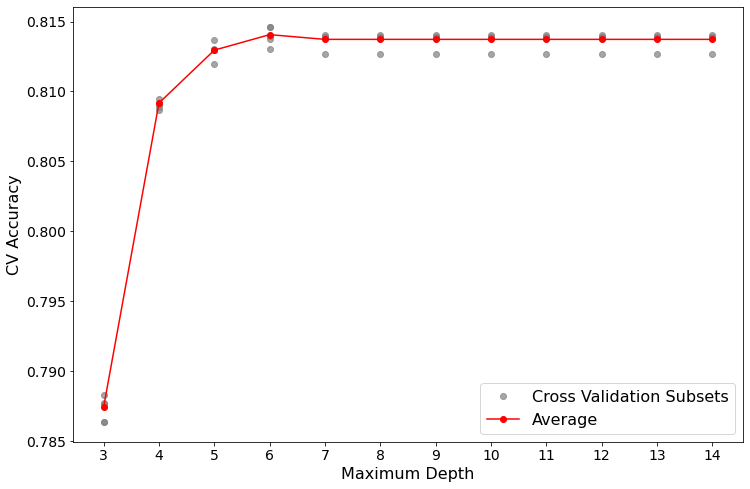

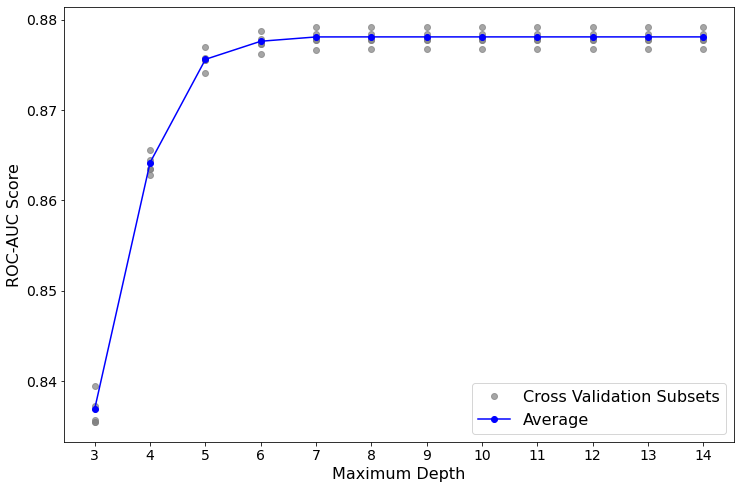

In [8]:
## this plots the average accuracy and accuracy for the CV subsets as a function of the maximum depth
plt.figure(figsize=(12,8))

#plot CV accuracies (one outside loop for non-repeating legend)
plt.plot(depth,cv_accs[1,1:],'o',color='gray',alpha=.7,label='Cross Validation Subsets') 
for i in range(1,5):
    plt.plot(depth,cv_accs[i,1:],'o',color='gray',alpha=.7,label='_no_legend_')
    
#Plot average CV accuracy 
plt.plot(depth,np.mean(cv_accs[:,1:], axis=0),
         '-o',color='red',
         label="Average")

plt.legend(fontsize=16)

plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("CV Accuracy", fontsize=16)

plt.xticks(depth, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## this plots the average ROC-AUC and ROC-AUC for the CV subsets as a function of the maximum depth
plt.figure(figsize=(12,8))

#plot CV ROC-AUC scores (one outside loop for non-repeating legend)
plt.plot(depth,cv_aucs[1,1:],'o',color='gray',alpha=.7,label='Cross Validation Subsets') 
for i in range(1,5):
    plt.plot(depth,cv_aucs[i,1:],'o',color='gray',alpha=.7,label='_no_legend_')
    
#Plot average CV accuracy 
plt.plot(depth,np.mean(cv_aucs[:,1:], axis=0),
         '-o',color='blue',
         label="Average")

plt.legend(fontsize=16)

plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("ROC-AUC Score", fontsize=16)

plt.xticks(depth, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [9]:
dtree=DecisionTreeClassifier(max_depth=6,random_state=10475)
fig=dtree.fit(X_train, y_train)

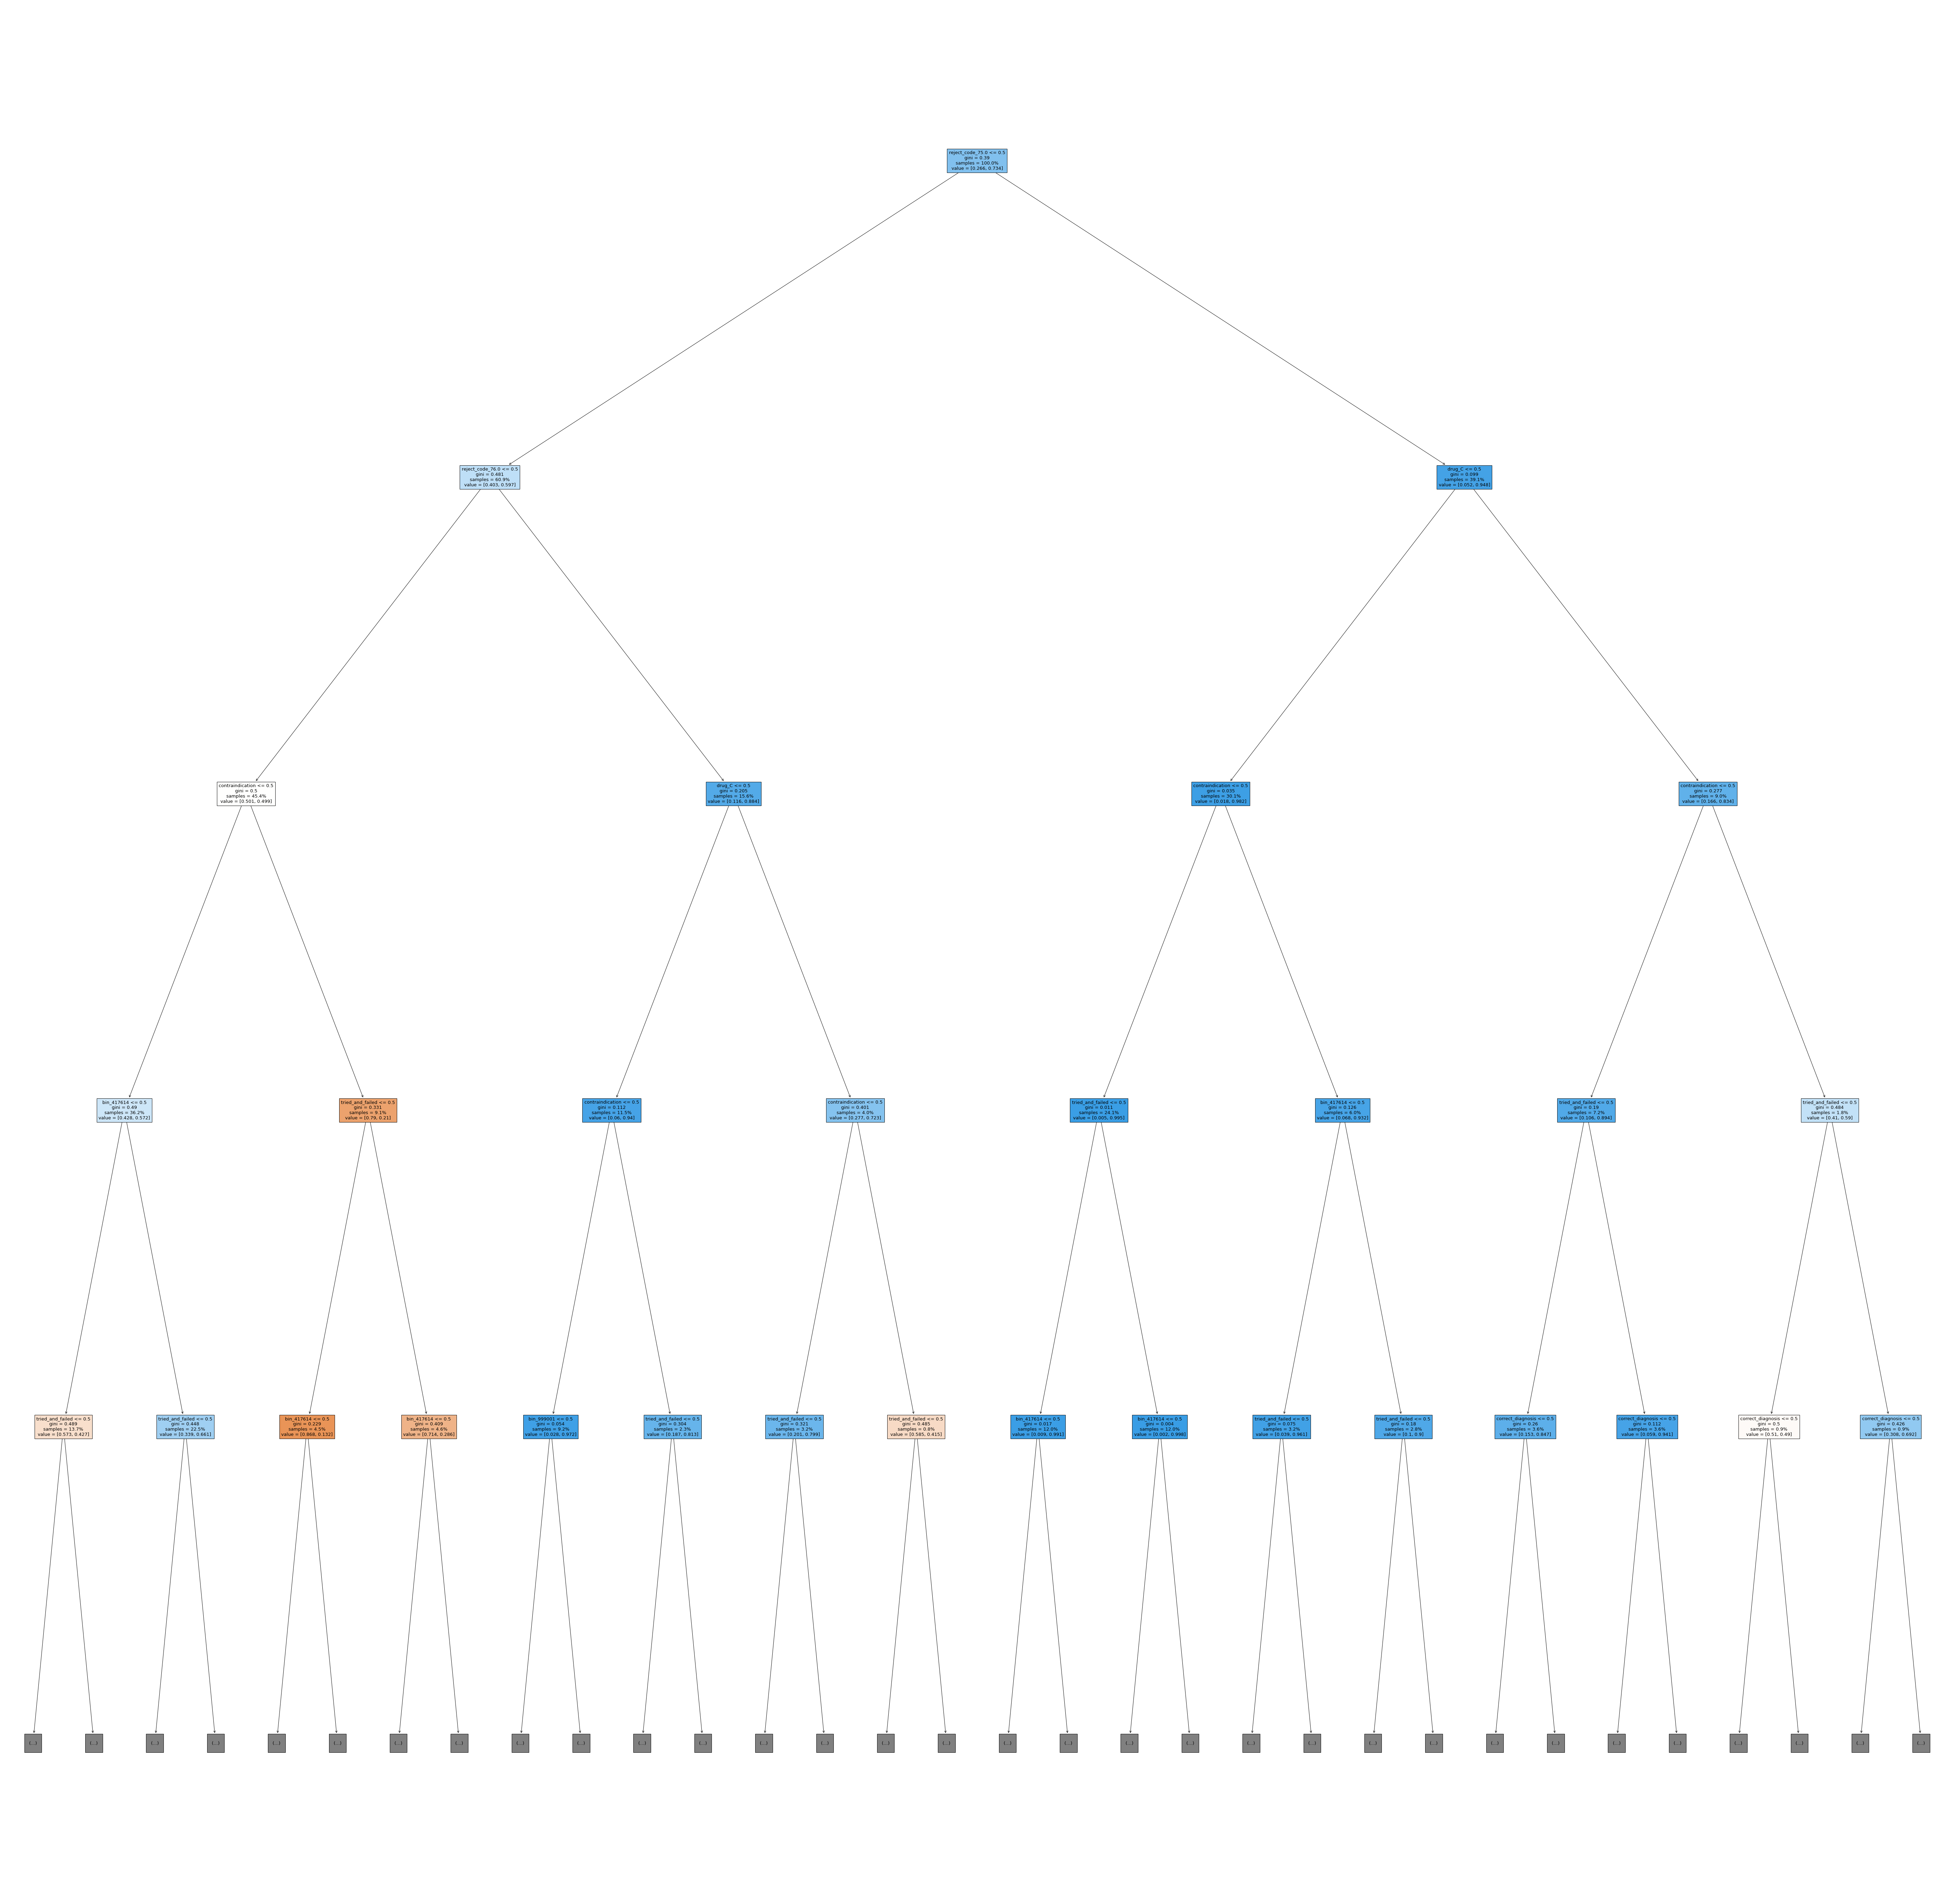

In [10]:
plt.figure(figsize = (100,100))

## Plot the fitted tree
tree.plot_tree(fig,label='all', filled = True,max_depth=4,feature_names=X_train.columns,proportion=True)
plt.savefig("pa_form_dec_tree.png")